## Pré-traitement des grilles

In [1]:
import os
import grass.script as gscript
import numpy as np
from scipy.interpolate import griddata
import xarray as xr
import grass.script.setup as gsetup
import matplotlib.pyplot as plt

In [2]:
# Répertoires fichiers grilles
rep = '/home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge/'
# Chemins des rasters à fusionner
input1 = rep + "munida50m_wgs84_EPSG_4326.nc"
input2 = rep + "MNT_NC100m_TSUCAL_GEO_refNM_ZNEG_V1.0.grd"
output = rep + "fused_dem_new"

# Ouvrir le fichier .grd
ds1 = xr.open_dataset(input1)

# Ouvrir le fichier .grd
ds2 = xr.open_dataset(input2, engine='netcdf4')

# Extraire les variables et les coordonnées
z1 = ds1['Band1'].values #munida50WGS84
lon1 = ds1['lon'].values
lat1 = ds1['lat'].values

z2 = ds2['z'].values
lon2 = ds2['x'].values
lat2 = ds2['y'].values

# Sous-échantillonnage ou réduction temporaire de la résolution (facultatif)
z1 = z1[::10, ::10]
lon1 = lon1[::10]
lat1 = lat1[::10]

z2 = z2[::10, ::10]
lon2 = lon2[::10]
lat2 = lat2[::10]

# Création de la grille pour le premier dataset
lon1_grid, lat1_grid = np.meshgrid(lon1, lat1)

# Création de la grille pour le second dataset
lon2_grid, lat2_grid = np.meshgrid(lon2, lat2)

In [3]:
z1[z1 == 0] = np.nan

## VISU

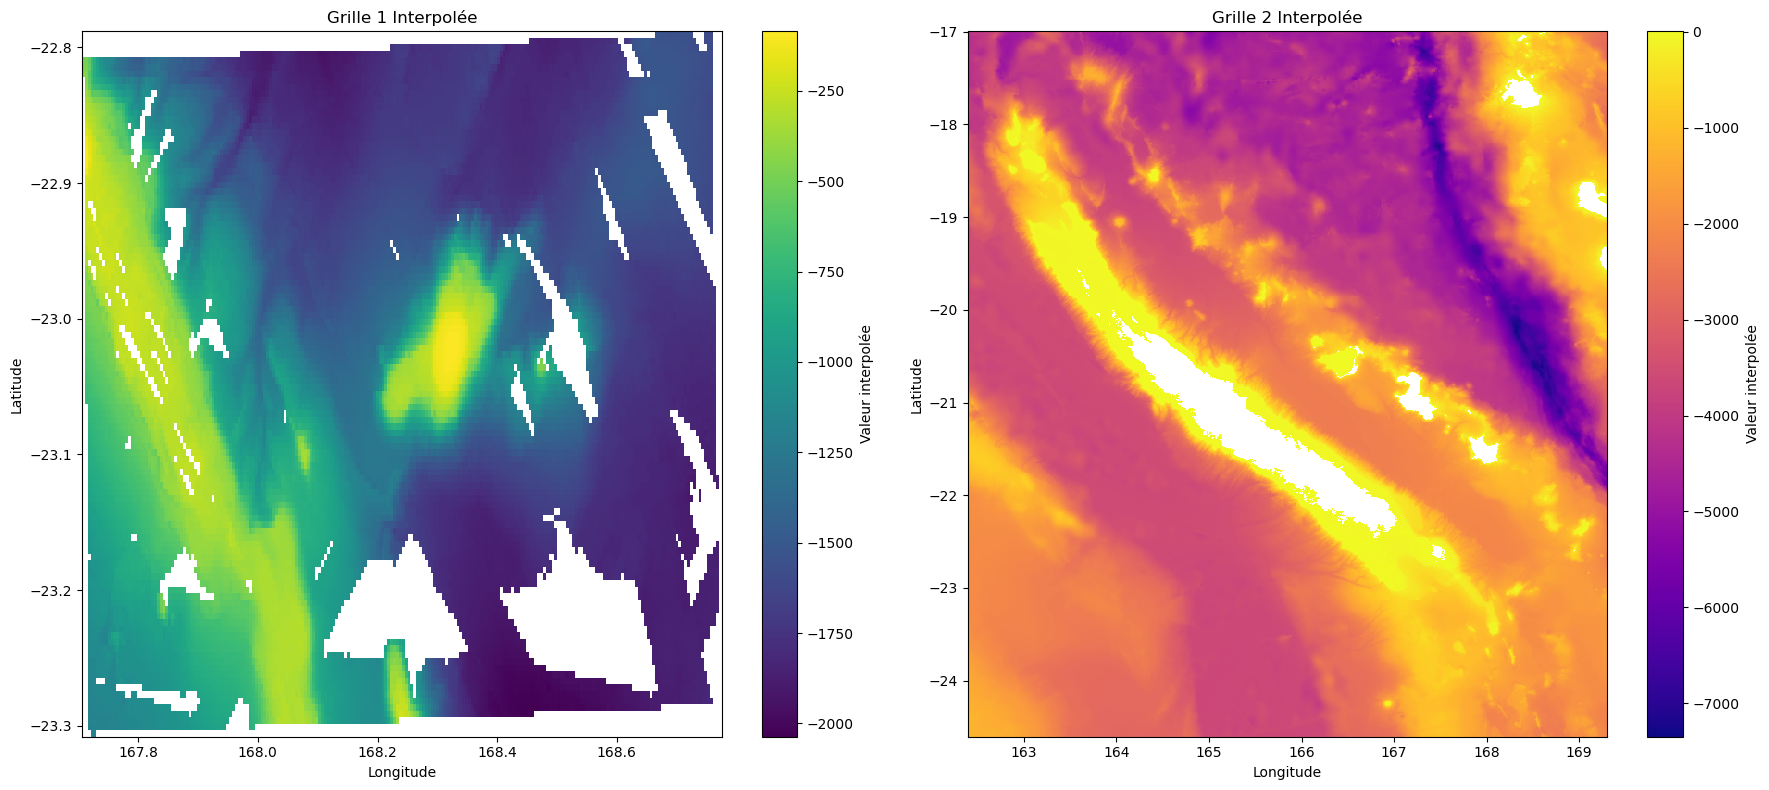

In [5]:
# Création de la figure avec deux sous-grilles côte à côte
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Premier plot avec pcolormesh
c1 = ax[0].pcolormesh(lon1_grid, lat1_grid, z1, shading='auto', cmap='viridis')
ax[0].set_title('Grille 1 Interpolée')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
fig.colorbar(c1, ax=ax[0], label='Valeur interpolée')

# Deuxième plot avec pcolormesh
c2 = ax[1].pcolormesh(lon2_grid, lat2_grid, z2, shading='auto', cmap='plasma')
ax[1].set_title('Grille 2 Interpolée')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
fig.colorbar(c2, ax=ax[1], label='Valeur interpolée')

# Ajuster l'espacement entre les sous-grilles
plt.tight_layout()

# Afficher la figure
plt.show()

## SAUVEGARDE TIFF

In [6]:
import xarray as xr
import numpy as np
import rioxarray

# Créer un Dataset xarray pour les grilles interpolées
ds1_interp = xr.Dataset(
    {'z1': (['lat', 'lon'], z1)},
    coords={
        'lon': (['lon'], np.unique(lon1_grid[0, :])),
        'lat': (['lat'], np.unique(lat1_grid[:, 0]))
    }
)

ds2_interp = xr.Dataset(
    {'z2': (['lat', 'lon'], z2)},
    coords={
        'lon': (['lon'], np.unique(lon2_grid[0, :])),
        'lat': (['lat'], np.unique(lat2_grid[:, 0]))
    }
)

# Définir les dimensions spatiales
ds1_interp.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
ds2_interp.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)

# Sauvegarder les grilles interpolées en GeoTIFF
ds1_interp.rio.to_raster(rep + 'grille1_highres.tif')
ds2_interp.rio.to_raster(rep + 'grille2_lowres.tif')

print("Les fichiers TIFF ont été sauvegardés.")


Les fichiers TIFF ont été sauvegardés.


## TRAITEMENT GRASS

In [1]:
import os
import grass.script as gscript
import numpy as np
from scipy.interpolate import griddata
import xarray as xr
import grass.script.setup as gsetup
import matplotlib.pyplot as plt

In [10]:
# Configurer les paramètres de GRASS
gisbase = "/usr/lib/grass78"  # Chemin vers l'installation de GRASS
gisdbase = "/home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge"  # Répertoire contenant tes Locations
location = "NC_merge_test"  # Nom de la Location correspondant à la Nouvelle-Calédonie
mapset = "NC_fusion"  # Mapset à utiliser, par défaut "PERMANENT"

# Définir les variables d'environnement nécessaires
os.environ['GISBASE'] = gisbase
os.environ['GISDBASE'] = gisdbase
os.environ['LOCATION_NAME'] = location
os.environ['MAPSET'] = mapset

# Initialiser GRASS
gsetup.init(gisbase, gisdbase, location, mapset)

#INPUTS
input1= rep + 'grille1_highres.tif'
input2= rep + 'grille2_lowres.tif'
output= "fusion_grilles"

In [3]:
rep = '/home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge/'
#INPUTS
input1= rep + 'grille1_highres.tif'
input2= rep + 'grille2_lowres.tif'
output= "fusion_grilles"

In [4]:
import subprocess

def reprojeter_raster(input_file, output_file):
    try:
        subprocess.run([
            'gdalwarp', 
            '-t_srs', 'EPSG:4326', 
            input_file, 
            output_file
        ], check=True)
        print(f"Raster reprojeté avec succès : {output_file}")
    except subprocess.CalledProcessError as e:
        print(f"Erreur lors de la reprojection : {e}")

# Définir les chemins des fichiers
output_file_2 = input2[:-4]+'_reproj_WGS84.tif'
output_file_1 = input1[:-4]+'_reproj_WGS84.tif'

# Reprojeter le raster
reprojeter_raster(input1, output_file_1)
reprojeter_raster(input2, output_file_2)

Processing /home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge/grille1_highres.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Raster reprojeté avec succès : /home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge/grille1_highres_reproj_WGS84.tif
Processing /home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge/grille2_lowres.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Raster reprojeté avec succès : /home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge/grille2_lowres_reproj_WGS84.tif


In [5]:
#Les inputs sont désormais les grilles reprojetées en WGS84
input2= output_file_2
input1= output_file_1
#Donner des noms aux rasters de l'environnement grass
raster1 = 'raster1_final'
raster2 = 'raster2_final'

#Charger les fichiers dans grass
gscript.run_command('r.in.gdal', input=input1, output=raster1)
gscript.run_command('r.in.gdal', input=input2, output=raster2)

#Définir la région d'étude (rectangle)
gscript.run_command('g.region', raster=f"{raster1},{raster2}")
#gscript.run_command('g.region', raster=raster2)


FileNotFoundError: [Errno 2] No such file or directory: 'r.in.gdal'

In [20]:
# Exécuter la commande r.mblend
gscript.run_command('r.mblend',
                    high=raster1,
                    low=raster2,
                    output=output)

Region:
{'projection': 3, 'zone': 0, 'n': -16.995, 's': -24.605, 'w': 162.395, 'e': 169.305, 'nsres': 0.00481645569620253, 'ewres': 0.00481533101045298, 'rows': 1580, 'cols': 1435, 'cells': 2267300}


[r.mblend] Resampling low resolution raster to higher resolution
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
[r.mblend] Multiplying low resolution by zero
[r.mblend] Multiplying high resolution by zero
[r.mblend] Computing extent of low resolution
Extraction des entités surfaciques...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Écriture des lignes...
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
Construction de la topologie pour la carte vectorielle
<tmp_800233@NC_fusion>...
Référencement des primitives ...
Construction des surfaces ...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100

0

In [21]:
gscript.run_command('r.out.gdal', input=output, output=[rep + output + '.tif'], format='GTiff')


Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value -nan
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: /home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge/fusion_grilles.tif, band 1: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal terminé. File
</home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge/fusion_grilles.tif>
created.


0